In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time
import pickle
import pandas as pd

from sceb.util import *
import sceb.data_loader as dl
import sceb.scdd as sd
import sceb.scdd_extra as sde
import scanpy.api as sc

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Import the data

In [2]:
input_folder = '/data/martin/single_cell/rna_fish_descend/'
file_dropseq = input_folder + 'dropseqFish.txt'
file_fish = input_folder + 'fishSubset.txt'
file_libsize = input_folder + 'libSize.txt'
df_fish = pd.read_table(file_fish, delimiter=' ')
df_dropseq = pd.read_table(file_dropseq, delimiter=' ')
df_dropseq = pd.DataFrame.transpose(df_dropseq)
df_libsize = pd.read_table(file_libsize, delimiter=' ')
gene_list = list(df_dropseq.columns)
n_gene = len(gene_list)
# Filter and normalize the fish data
fish_ind = np.array((df_fish['GAPDH']>100)&(df_fish['GAPDH']<1000), dtype=bool)
df_fish = df_fish[fish_ind]
# Filter the dropseq data
dropseq_ind = np.array(df_libsize[:]>1000, dtype=bool)
n_cell = np.sum(dropseq_ind)
df_dropseq = df_dropseq[dropseq_ind]
df_libsize = df_libsize[dropseq_ind]
output_folder = '/home/martin/single_cell_eb/figures/figure_smfish'

## Consistency between Dropseq and rnaFISH

In [3]:
# Estimation for Dropseq
ann_dropseq = sc.AnnData(df_dropseq)
ann_dropseq.X = scipy.sparse.csr_matrix(ann_dropseq.X)
size_factor = np.array(df_libsize/np.mean(df_libsize)).reshape([-1])
# CV
cv_dropseq_ml = np.zeros([n_gene], dtype=float)
cv_dropseq_dd = np.zeros([n_gene], dtype=float)
size_factor = np.array(df_libsize/np.mean(df_libsize)).reshape([-1])
for i_gene,gene in enumerate(gene_list):
    temp = df_dropseq[gene].as_matrix()
    cv_dropseq_ml[i_gene],cv_dropseq_dd[i_gene] = sde.cv_single(temp, size_factor=size_factor)
p0_dropseq_ml,p0_dropseq_dd = sd.dd_inactive_prob(ann_dropseq,
                                                  size_factor=size_factor,relative_depth=0.4)
# Bad genes 
gene_list = list(ann_dropseq.var_names)
n_gene = len(gene_list)
ind_bad = p0_dropseq_ml>0.97
for i_gene,gene in enumerate(gene_list):
    if gene in ['FOSL1', 'GAPDH']:
        ind_bad[i_gene] = True

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/martin/single_cell_eb/sceb/scdd_extra.py:220: RuntimeWarning: invalid value encountered in double_scalars
  cv_ml = np.std(Y_ml) / np.mean(Y_ml)
/home/martin/single_cell_eb/sceb/scdd_extra.py:225: RuntimeWarning: invalid value encountered in double_scalars
  cv_dd = np.sqrt(var_)/mean_


# time start: 0.0s
n_cell=5763, n_gene=26
# total time: 0.2s


In [4]:
# Estimation for rnaFISH
size_factor_fish = np.array(df_fish['GAPDH'])
size_factor_fish = size_factor_fish / np.mean(size_factor_fish)
X_fish = df_fish.as_matrix()
cv_fish = np.zeros([n_gene], dtype=float)
p0_fish = np.zeros([n_gene], dtype=float)-1
for i_gene,gene in enumerate(gene_list):
    # CV estimation
    temp = X_fish[:, i_gene]
    ind_select = ~np.isnan(temp)
    temp = temp[ind_select]
    temp_size = size_factor_fish[ind_select]
    cv_fish[i_gene] = sde.cv_single_fish(temp, size_factor=temp_size)
    # Inactive probability with 2x deeper sequencing than Dropseq
    Y_dropseq = np.array(df_dropseq[gene], dtype=int)
    if temp.shape[0] < n_cell:
        continue
    temp_sub,_,success_flag = sde.subsample_single_gene(temp, n_cell, 
                                                        int(Y_dropseq.sum()*2.5),
                                                        random_state=0)
    if success_flag:
        p0_fish[i_gene] = np.mean(temp_sub==0)
    

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


not enough reads! 


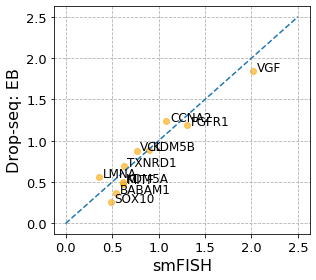

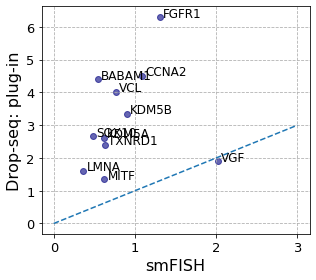

In [5]:
plt.figure(figsize=[4.5,4])
# plt.subplot(121)
plt.scatter(cv_fish[~ind_bad], cv_dropseq_dd[~ind_bad], color='orange', alpha=0.6)
plt.plot([0,2.5],[0,2.5], linestyle='--')
plt.xlabel('smFISH')
plt.ylabel('Drop-seq: EB')
for i in range(n_gene):
    if ~ind_bad[i]:
        plt.annotate(gene_list[i], (cv_fish[i]+0.04, cv_dropseq_dd[i]), fontsize=12)
#         plt.annotate(gene_list[i], (cv_fish[i]+0.04, cv_dropseq_dd[i]), fontsize=12)
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig(output_folder + '/cv_dropseq_eb.pdf')
plt.show()

plt.figure(figsize=[4.5,4])
plt.scatter(cv_fish[~ind_bad], cv_dropseq_ml[~ind_bad], color='navy', alpha=0.6)
plt.plot([0,3],[0,3], linestyle='--')
plt.xlabel('smFISH')
plt.ylabel('Drop-seq: plug-in')
for i in range(n_gene):
    if ~ind_bad[i]:
        plt.annotate(gene_list[i], (cv_fish[i]+0.04, cv_dropseq_ml[i]), fontsize=12)
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig(output_folder + '/cv_dropseq_plugin.pdf')
plt.show()

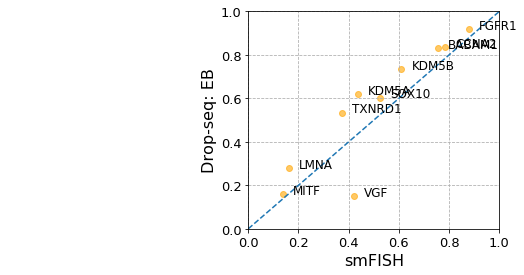

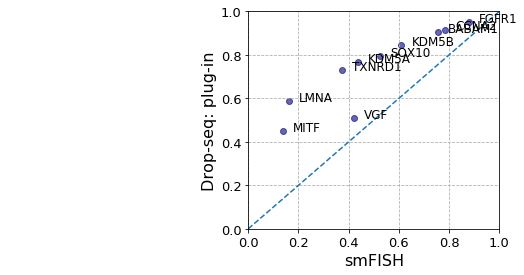

In [22]:
# plt.figure(figsize=[4.5,4])
plt.figure(figsize=[4.5,4])
plt.scatter(p0_fish[~ind_bad], p0_dropseq_dd[~ind_bad], color='orange', alpha=0.6)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('smFISH')
plt.ylabel('Drop-seq: EB')
plt.xlim([0,1])
plt.ylim([0,1])
for i in range(n_gene):
    if ~ind_bad[i]:
        plt.annotate(gene_list[i], (p0_fish[i]+0.04, p0_dropseq_dd[i]), fontsize=12)
plt.grid(linestyle='--')
# plt.tight_layout()
plt.savefig(output_folder + '/p0_dropseq_eb.pdf')
plt.show()
plt.figure(figsize=[4.5,4])
plt.scatter(p0_fish[~ind_bad], p0_dropseq_ml[~ind_bad], color='navy', alpha=0.6)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('smFISH')
plt.ylabel('Drop-seq: plug-in')
for i in range(n_gene):
    if ~ind_bad[i]:
        plt.annotate(gene_list[i], (p0_fish[i]+0.04, p0_dropseq_ml[i]), fontsize=12)
# plt.suptitle('inactive probability $\kappa=2$')
# plt.tight_layout()
plt.grid(linestyle='--')
plt.savefig(output_folder + '/p0_dropseq_plugin.pdf')
plt.show()

## Subsampling experiment

In [14]:
for i_gene,gene in enumerate(gene_list):
    if ~ind_bad[i_gene]:
        print('%s, mean_ds=%0.3f, cv_df=%0.3f, cv_fish=%0.3f'%
              (gene, df_dropseq[gene].mean(), cv_dropseq_dd[i_gene], cv_fish[i_gene]))

SOX10, mean_ds=0.298, cv_df=0.261, cv_fish=0.487
CCNA2, mean_ds=0.114, cv_df=1.242, cv_fish=1.085
MITF, mean_ds=1.554, cv_df=0.483, cv_fish=0.623
FGFR1, mean_ds=0.060, cv_df=1.190, cv_fish=1.305
VGF, mean_ds=2.353, cv_df=1.847, cv_fish=2.018
BABAM1, mean_ds=0.116, cv_df=0.362, cv_fish=0.544
KDM5A, mean_ds=0.403, cv_df=0.503, cv_fish=0.613
LMNA, mean_ds=0.979, cv_df=0.564, cv_fish=0.363
KDM5B, mean_ds=0.238, cv_df=0.883, cv_fish=0.897
VCL, mean_ds=0.168, cv_df=0.882, cv_fish=0.764
TXNRD1, mean_ds=0.508, cv_df=0.694, cv_fish=0.625


In [15]:
cv_fish_dic = {}
cv_dropseq_dic = {}
for i_gene,gene in enumerate(gene_list):
    cv_fish_dic[gene] = cv_fish[i_gene]
    cv_dropseq_dic[gene] = cv_dropseq_dd[i_gene]
exp_list = ['VGF', 'MITF'] 
res_cv = {}
for gene in exp_list:
    Y_gene = np.array(df_dropseq[gene])
    B_list = [300, 500, 800]
    res_cv[gene] = sde.simulate_tradeoff_cv_single(Y_gene, gene, B_list,
                                                   size_factor, n_rep=5000)

VGF Nr_bar=2.353
B=300, Nr_bar_new=0.053
B=300, Nr_bar_new=0.073
B=300, Nr_bar_new=0.101
B=300, Nr_bar_new=0.140
B=300, Nr_bar_new=0.195
B=300, Nr_bar_new=0.270
B=300, Nr_bar_new=0.375
B=300, Nr_bar_new=0.520
B=300, Nr_bar_new=0.721
B=300, Nr_bar_new=1.000
B=500, Nr_bar_new=0.088
B=500, Nr_bar_new=0.115
B=500, Nr_bar_new=0.151
B=500, Nr_bar_new=0.197
B=500, Nr_bar_new=0.259
B=500, Nr_bar_new=0.339
B=500, Nr_bar_new=0.444
B=500, Nr_bar_new=0.582
B=500, Nr_bar_new=0.763
B=500, Nr_bar_new=1.000
B=800, Nr_bar_new=0.140
B=800, Nr_bar_new=0.174
B=800, Nr_bar_new=0.217
B=800, Nr_bar_new=0.270
B=800, Nr_bar_new=0.336
B=800, Nr_bar_new=0.418
B=800, Nr_bar_new=0.520
B=800, Nr_bar_new=0.646
B=800, Nr_bar_new=0.804
B=800, Nr_bar_new=1.000
MITF Nr_bar=1.554
B=300, Nr_bar_new=0.053
B=300, Nr_bar_new=0.073
B=300, Nr_bar_new=0.101
B=300, Nr_bar_new=0.140
B=300, Nr_bar_new=0.195
B=300, Nr_bar_new=0.270
B=300, Nr_bar_new=0.375
B=300, Nr_bar_new=0.520
B=300, Nr_bar_new=0.721
B=300, Nr_bar_new=1.000
B=500

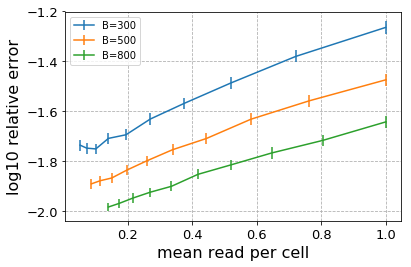

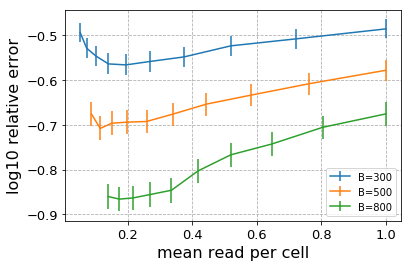

In [16]:
# for gene in exp_list:
for gene in exp_list:
    temp_res = res_cv[gene]
    B_list = list(temp_res.keys())
    plt.figure()
    for B in B_list:
        cv_ml = temp_res[B]['cv_ml']
        cv_dd = temp_res[B]['cv_dd']
        Nr_bar_new_list = temp_res[B]['Nr_bar_new_list']
        error_dd = (cv_dd - cv_fish_dic[gene])**2 / (cv_fish_dic[gene]**2)
#         error_dd = (cv_dd - cv_dropseq_dic[gene])**2 / (cv_dropseq_dic[gene]**2)
        mean_err = np.nanmean(error_dd, axis=0)
        std_err = np.nanstd(error_dd, axis=0) / np.sqrt(np.sum(~np.isnan(error_dd), axis=0))
        y_val = np.log10(mean_err)
        y_err = np.log10(mean_err+std_err) - np.log10(mean_err)
        
        plt.errorbar(Nr_bar_new_list, y_val, y_err*3, label='B=%d'%(B))
    plt.xlabel('mean read per cell')
    plt.ylabel('log10 relative error')
    plt.legend()
    plt.grid(linestyle='--')
    plt.tight_layout()
    plt.savefig(output_folder + '/cv_tradeoff_%s.pdf'%gene)
    plt.show()

In [17]:
exp_list = ['VGF', 'MITF'] 
# exp_list = ['VGF'] 
res_p0 = {}
for gene in exp_list:
    Y_gene = np.array(df_dropseq[gene])
    B_list = [300, 500, 800]
    res_p0[gene] = sde.simulate_tradeoff_p0_single(Y_gene, gene, B_list,
                                                   size_factor, n_rep=200)

VGF Nr_bar=2.353
B=300, Nr_bar_new=0.053
B=300, Nr_bar_new=0.073
B=300, Nr_bar_new=0.101
B=300, Nr_bar_new=0.140
B=300, Nr_bar_new=0.195
B=300, Nr_bar_new=0.270
B=300, Nr_bar_new=0.375
B=300, Nr_bar_new=0.520
B=300, Nr_bar_new=0.721
B=300, Nr_bar_new=1.000
B=500, Nr_bar_new=0.088
B=500, Nr_bar_new=0.115
B=500, Nr_bar_new=0.151
B=500, Nr_bar_new=0.197
B=500, Nr_bar_new=0.259
B=500, Nr_bar_new=0.339
B=500, Nr_bar_new=0.444
B=500, Nr_bar_new=0.582
B=500, Nr_bar_new=0.763
B=500, Nr_bar_new=1.000
B=800, Nr_bar_new=0.140
B=800, Nr_bar_new=0.174
B=800, Nr_bar_new=0.217
B=800, Nr_bar_new=0.270
B=800, Nr_bar_new=0.336
B=800, Nr_bar_new=0.418
B=800, Nr_bar_new=0.520
B=800, Nr_bar_new=0.646
B=800, Nr_bar_new=0.804
B=800, Nr_bar_new=1.000
MITF Nr_bar=1.554
B=300, Nr_bar_new=0.053
B=300, Nr_bar_new=0.073
B=300, Nr_bar_new=0.101
B=300, Nr_bar_new=0.140
B=300, Nr_bar_new=0.195
B=300, Nr_bar_new=0.270
B=300, Nr_bar_new=0.375
B=300, Nr_bar_new=0.520
B=300, Nr_bar_new=0.721
B=300, Nr_bar_new=1.000
B=500

In [18]:
p0_fish_dic = {}
np.random.seed(0)
for gene in exp_list:
    temp = np.array(df_fish[gene])
    ind_select = ~np.isnan(temp)
    temp = temp[ind_select]
    temp_sub,_,success_flag = sde.subsample_single_gene(temp, n_cell, 
                                                        int(n_cell),
                                                        random_state=0)
    if success_flag:
        p0_fish_dic[gene] = np.mean(temp_sub==0)

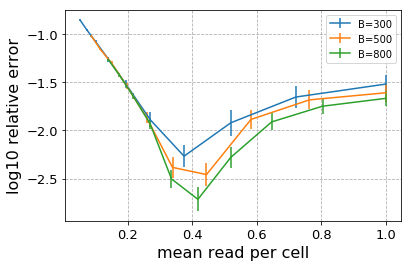

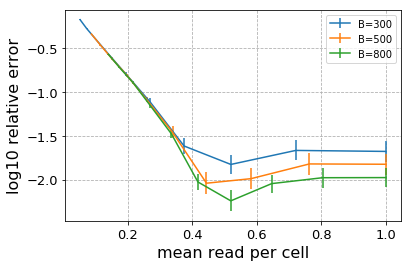

In [19]:
# for gene in exp_list:
for gene in exp_list:
    temp_res = res_p0[gene]
    B_list = list(temp_res.keys())
    plt.figure()
    for B in B_list:
        p0_ml = temp_res[B]['p0_ml']
        p0_dd = temp_res[B]['p0_dd']
        Nr_bar_new_list = temp_res[B]['Nr_bar_new_list']
        error_dd = (p0_dd - p0_fish_dic[gene])**2 / (p0_fish_dic[gene]**2)
#         error_dd = (cv_dd - cv_dropseq_dic[gene])**2 / (cv_dropseq_dic[gene]**2)
        mean_err = np.nanmean(error_dd, axis=0)
        std_err = np.nanstd(error_dd, axis=0) / np.sqrt(np.sum(~np.isnan(error_dd), axis=0))
        y_val = np.log10(mean_err)
        y_err = np.log10(mean_err+std_err) - np.log10(mean_err)
        
        plt.errorbar(Nr_bar_new_list, y_val, y_err*3, label='B=%d'%(B))
    plt.xlabel('mean read per cell')
    plt.ylabel('log10 relative error')
    plt.legend()
    plt.grid(linestyle='--')
    plt.tight_layout()
    plt.savefig(output_folder + '/p0_tradeoff_%s.pdf'%gene)
    plt.show()